# PART A

## Setup

In [ ]:
%matplotlib inline
!pip install tabulate

import time
import pandas as pd

from src.geometry.random_points import random_points_2d
from src.geometry.plotting import plot_points_and_hull
from src.algorithms.hull2d_incremental import convex_hull_incremental
from src.algorithms.hull2d_jarvis import convex_hull_jarvis
from src.algorithms.hull2d_divide_conquer import convex_hull_dc
from src.algorithms.hull2d_quickhull import convex_hull_quickhull

algo = {
    "Incremental (Monotone Chain)": convex_hull_incremental,
    "Jarvis": convex_hull_jarvis,
    "Divide & Conquer": convex_hull_dc,
    "QuickHull": convex_hull_quickhull,
}

def run_and_plot(name, func, points):
    print(f"\nRunning: {name}")
    hull = func(points)
    print(f"Points: {len(points)} | Hull vertices: {len(hull)}")
    plot_points_and_hull(points, hull, show=True, title=name)
    return hull

def same_vertex_set(h1, h2):
    # Compare hulls as sets of vertices
    return {(p.x, p.y) for p in h1} == {(p.x, p.y) for p in h2}

## Run all 2D convex hull algorithms (n=200) and compare results


Running: Incremental (Monotone Chain)
Points: 200 | Hull vertices: 16


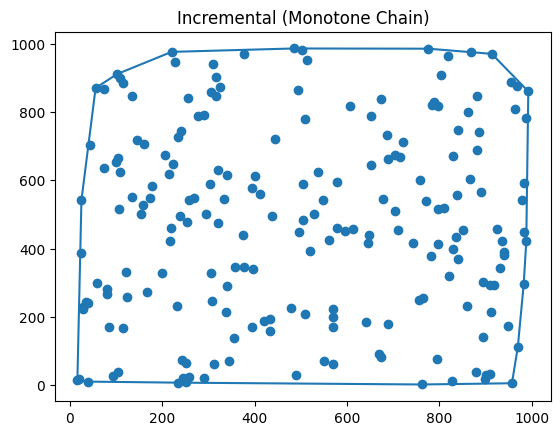


Running: Jarvis
Points: 200 | Hull vertices: 16


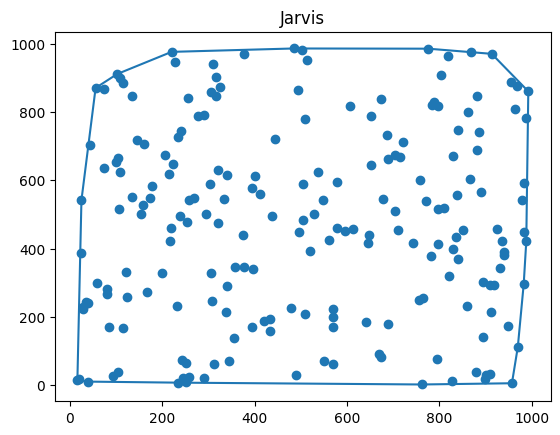


Running: Divide & Conquer
Points: 200 | Hull vertices: 16


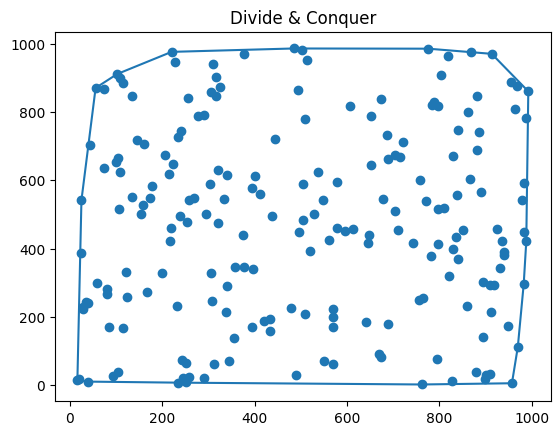


Running: QuickHull
Points: 200 | Hull vertices: 16


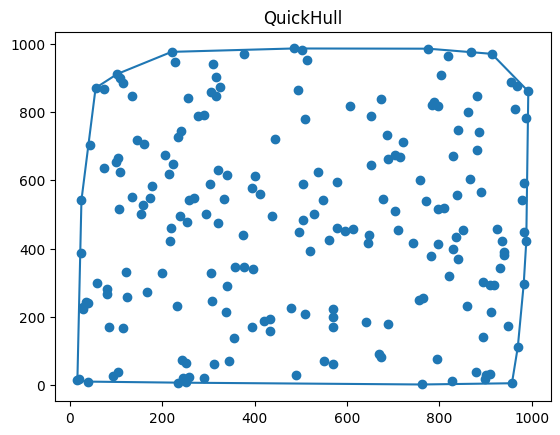

All algorithms produced the same convex hull (same set of hull vertices).


In [30]:
# Generate random points
points = random_points_2d(200, seed=1, lo=0, hi=1000)

hulls = {}
for name, func in algo.items():
    # Run each algorithm and store its hull
    filename = name.lower().replace(" ", "_").replace("(", "").replace(")", "")
    hulls[name] = run_and_plot(name, func, points)

ref = "Incremental (Monotone Chain)"  # Use monotone chain as reference
ref_set = {(p.x, p.y) for p in hulls[ref]}

# Check if any algorithm returns a different set of hull vertices
diff = [name for name, h in hulls.items() if {(p.x, p.y) for p in h} != ref_set]

if not diff:
    print("All algorithms produced the same convex hull (same set of hull vertices).")
else:
    print(f"Different result compared to the reference ({ref}) produced by:", diff)

## Performance Comparison

In [31]:
from IPython.display import Markdown,display

def time_one(func, points, repeats=3):
    ts = []
    for _ in range(repeats):
        t0 = time.perf_counter()
        vertices = func(points)
        ts.append(time.perf_counter() - t0)
    return sum(ts)/len(ts), min(ts), len(vertices)

Ns = [100, 200, 500, 1000, 2000, 5000]
repeats = 3

rows = []
for n in Ns:
    # New random input for each n
    pts = random_points_2d(n, seed=1000+n, lo=0, hi=1000000)
    for name, func in algo.items():
        mean_t, best_t, hsz = time_one(func, pts, repeats=repeats)
        rows.append({"n": n, "algorithm": name, "mean_s": mean_t, "best_s": best_t, "hull": hsz})

df = pd.DataFrame(rows)
table = df.pivot(index="n", columns="algorithm", values="mean_s").reset_index()
table = table.rename_axis(None, axis=1) 

# Average time per algorithm
overall = df.groupby("algorithm")["mean_s"].mean().sort_values()
overall_table = overall.reset_index(name="average time")

display(Markdown("### Timing table (mean_s)"))
display(Markdown(table.to_markdown(index=False)))

display(Markdown("### Average time per algorithm"))
display(Markdown(overall_table.to_markdown(index=False)))

print(f"Overall fastest on average: {overall_table.loc[0, 'algorithm']} (average time={overall_table.loc[0, 'average time']:.6f} s)")

### Timing table (mean_s)

|    n |   Divide & Conquer |   Incremental (Monotone Chain) |     Jarvis |   QuickHull |
|-----:|-------------------:|-------------------------------:|-----------:|------------:|
|  100 |         0.00130894 |                    0.000457929 | 0.00125395 | 0.000677982 |
|  200 |         0.00221134 |                    0.000749198 | 0.00192238 | 0.000949574 |
|  500 |         0.00367699 |                    0.00138601  | 0.00480287 | 0.00186088  |
| 1000 |         0.00648118 |                    0.00213302  | 0.010454   | 0.00385952  |
| 2000 |         0.0143531  |                    0.00454476  | 0.0202773  | 0.0075437   |
| 5000 |         0.0440443  |                    0.0136416   | 0.0736874  | 0.0822716   |

### Average time per algorithm

| algorithm                    |   average time |
|:-----------------------------|---------------:|
| Incremental (Monotone Chain) |     0.00381876 |
| Divide & Conquer             |     0.0120127  |
| QuickHull                    |     0.0161939  |
| Jarvis                       |     0.018733   |

Overall fastest on average: Incremental (Monotone Chain) (average time=0.003819 s)


## 3D Convex Hull (Incremental) — Visualization

Unique points: 180
Faces: 84
Hull vertices: 44


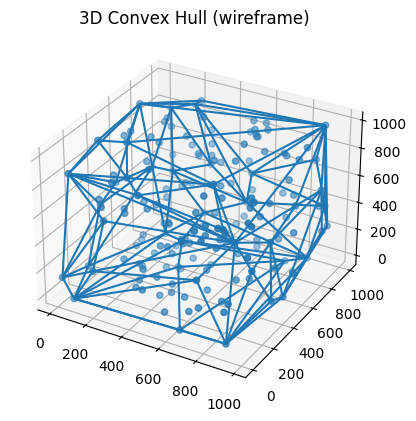

In [32]:
from src.geometry.random_points import random_points_3d
from src.algorithms.hull3d_incremental import convex_hull_3d_incremental
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection

# Generate random 3D points and compute the hull
pts3 = random_points_3d(180, seed=1, lo=0, hi=1000)
pts, faces = convex_hull_3d_incremental(pts3)

print("Unique points:", len(pts))
print("Faces:", len(faces))
print("Hull vertices:", len({i for f in faces for i in f}))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection="3d")
ax.scatter([p.x for p in pts], [p.y for p in pts], [p.z for p in pts])

edges = set()
for a, b, c in faces:
    edges.add(tuple(sorted((a, b))))
    edges.add(tuple(sorted((b, c))))
    edges.add(tuple(sorted((c, a))))

# Convert edges to 3D line segments
segments = [
    [(pts[i].x, pts[i].y, pts[i].z), (pts[j].x, pts[j].y, pts[j].z)]
    for (i, j) in edges
]

ax.add_collection3d(Line3DCollection(segments))
ax.set_title("3D Convex Hull (wireframe)")

plt.show()

# PART B

## 2D Linear Programming (Incremental Algorithm)

In [33]:
from src.algorithms.lp2d_incremental import solve_lp_incremental_2d, to_leq, obj, feasible

c1, c2 = -5.0, 12.0

constraints = [
    to_leq(1, -3, -3, ">="),   # x1 - 3x2 >= -3
    to_leq(6, 1, 8, ">="),     # 6x1 + x2 >= 8
    to_leq(-2, 7, 25, "<="),   # -2x1 + 7x2 <= 25
    to_leq(-1, 8, 31, "<="),   # -x1 + 8x2 <= 31
    to_leq(1, -1, 12, ">="),   # x1 - x2 >= 12
    to_leq(-1, 6, -2, ">="),   # -x1 + 6x2 >= -2
    to_leq(-3, 12, 6, ">="),   # -3x1 + 12x2 >= 6
    to_leq(1, 0, 0, ">="),     # x1 >= 0
    to_leq(0, 1, 0, ">="),    # x2 >= 0
]

p = solve_lp_incremental_2d(constraints, c1, c2, seed=0)
assert feasible(p, constraints)
#print("Feasible:", feasible(p, constraints))
print(f"Optimal point: (x1={p.x:.6f}, x2={p.y:.6f})")
print(f"Optimal value: {obj(p, c1, c2):.6f}")

Optimal point: (x1=18.142857, x2=6.142857)
Optimal value: -17.000000


## Visualization of the Feasible Region and the Optimal Solution

Feasible vertices found: 3


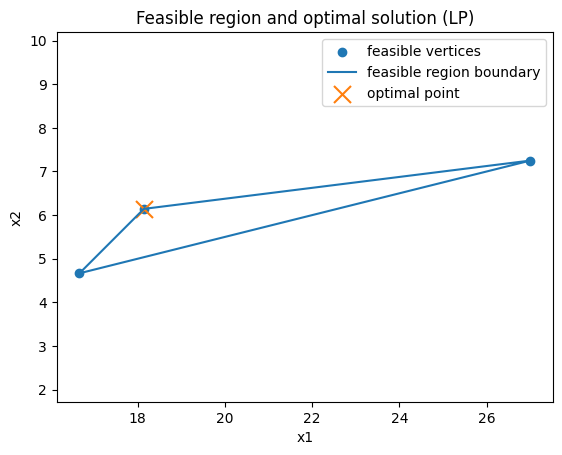

In [34]:
import matplotlib.pyplot as plt
from src.algorithms.lp2d_incremental import intersect_lines, feasible
from src.algorithms.hull2d_incremental import convex_hull_incremental

# Collect feasible vertices from pairwise intersections
verts = []
m = len(constraints)
for i in range(m):
    for j in range(i + 1, m):
        q = intersect_lines(constraints[i], constraints[j])
        if q is None:
            continue
        if feasible(q, constraints):
            verts.append(q)

print("Feasible vertices found:", len(verts))

# Boundary of the feasible region
poly = convex_hull_incremental(verts)

plt.figure()
plt.scatter([v.x for v in verts], [v.y for v in verts], label="feasible vertices")

# Draw boundary polygon
if len(poly) >= 2:
    xs = [u.x for u in poly] + [poly[0].x]
    ys = [u.y for u in poly] + [poly[0].y]
    plt.plot(xs, ys, label="feasible region boundary")

# Optimal point
plt.scatter([p.x], [p.y], marker="x", s=150, label="optimal point")

plt.title("Feasible region and optimal solution (LP)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.legend()
plt.show()

# PART C

## Imports

In [35]:
import matplotlib.pyplot as plt
from src.geometry.primitives2d import Point2D
from src.geometry.random_points import random_points_2d
from src.algorithms.delaunay_lifting import (delaunay_lifting_steps, delaunay_triangulation_lifting, triangulation_edges,)

## Delaunay (Lifting) — Basic Output (points & triangles)

In [36]:
pts = random_points_2d(50, seed=7, lo=0, hi=1000)
pts2, tris = delaunay_triangulation_lifting(pts)

print("Points:", len(pts2))
print("Triangles:", len(tris))
print("First triangles:", tris[:5])

Points: 50
Triangles: 88
First triangles: [(0, 2, 3), (0, 1, 5), (2, 4, 6), (0, 5, 7), (1, 0, 8)]


## Delaunay (Lifting) — Construction Steps (few points)

step 4: points=4, triangles=2, edges=5


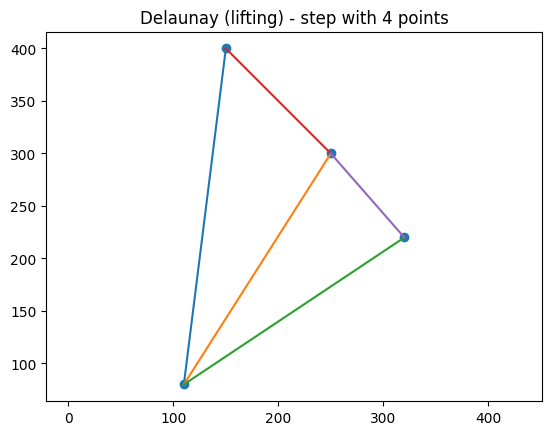

step 5: points=5, triangles=4, edges=8


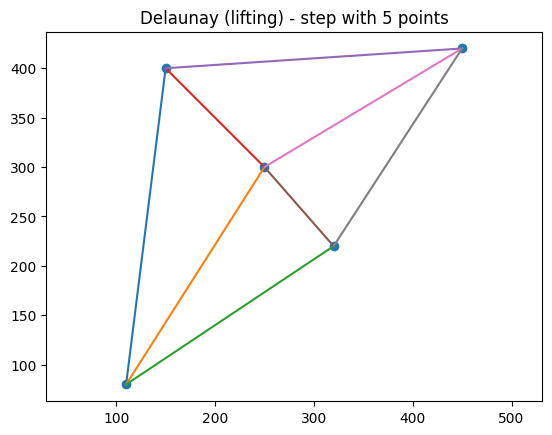

step 6: points=6, triangles=6, edges=11


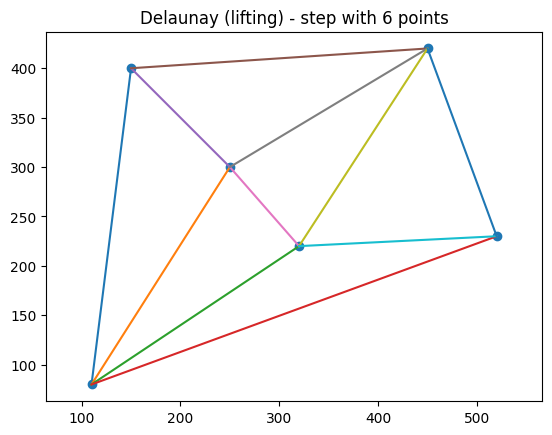

step 7: points=7, triangles=7, edges=13


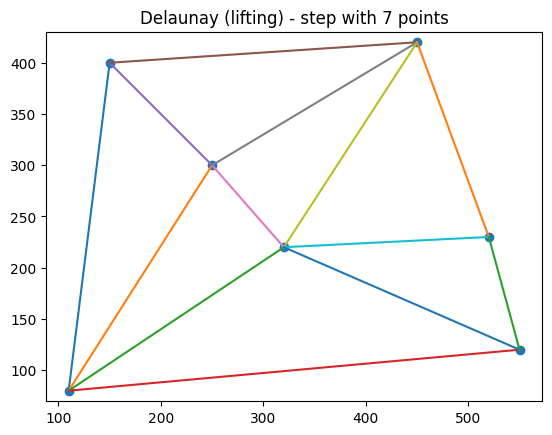

In [37]:
# Few points for step-by-step visualization
small = [
    Point2D(110, 80),
    Point2D(550, 120),
    Point2D(250, 300),
    Point2D(150, 400),
    Point2D(450, 420),
    Point2D(320, 220),
    Point2D(520, 230),
]

steps = delaunay_lifting_steps(small, start=4)

for k, (pts2, tris) in enumerate(steps, start=4):
    edges = triangulation_edges(tris)

    plt.figure()
    plt.scatter([p.x for p in pts2], [p.y for p in pts2])

    for i, j in edges:  # Draw edges
        plt.plot([pts2[i].x, pts2[j].x], [pts2[i].y, pts2[j].y])
    
    print(f"step {k}: points={len(pts2)}, triangles={len(tris)}, edges={len(edges)}")

    plt.title(f"Delaunay (lifting) - step with {k} points")
    plt.axis("equal")
    plt.show()

## Delaunay (Lifting) — Final Triangulation (random points)

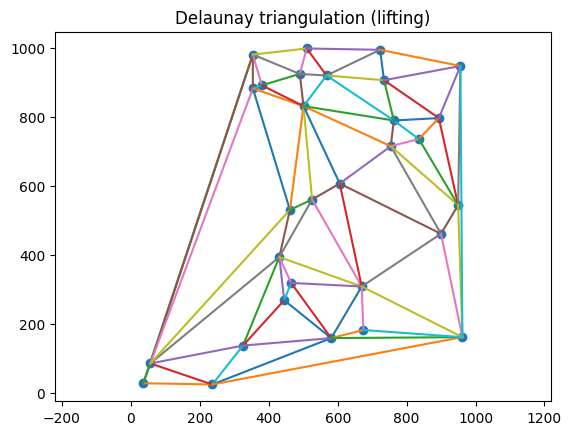

Points: 30
Triangles: 51
Edges: 80


In [38]:
# Random points
pts = random_points_2d(30, seed=2, lo=0, hi=1000)
# Delaunay triangulation
pts2, tris = delaunay_triangulation_lifting(pts)
edges = triangulation_edges(tris)

plt.figure()
plt.scatter([p.x for p in pts2], [p.y for p in pts2])

for i, j in edges:
    plt.plot([pts2[i].x, pts2[j].x], [pts2[i].y, pts2[j].y])

plt.title("Delaunay triangulation (lifting)")
plt.axis("equal")
plt.show()

print("Points:", len(pts2))
print("Triangles:", len(tris))
print("Edges:", len(edges))

# PART D

## Imports

In [39]:
from src.geometry.primitives2d import Point2D
from src.geometry.random_points import random_points_2d
from src.algorithms.kdtree import build_kdtree
from src.algorithms.range_search import Rect, range_search
from src.geometry.plotting import plot_kdtree, plot_range

## KD-tree — Build & Visualization (small set)

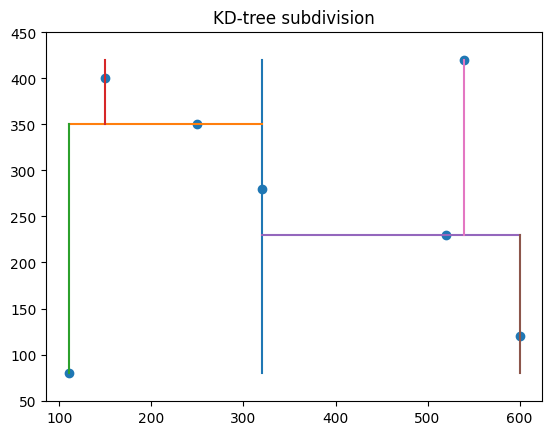

In [40]:
small = [
    Point2D(110, 80),
    Point2D(600, 120),
    Point2D(250, 350),
    Point2D(150, 400),
    Point2D(540, 420),
    Point2D(320, 280),
    Point2D(520, 230),
]
root = build_kdtree(small)
plot_kdtree(small, root, title="KD-tree subdivision")

## Range Query — Small Example

All reported points are inside the rectangle
Reported: 2


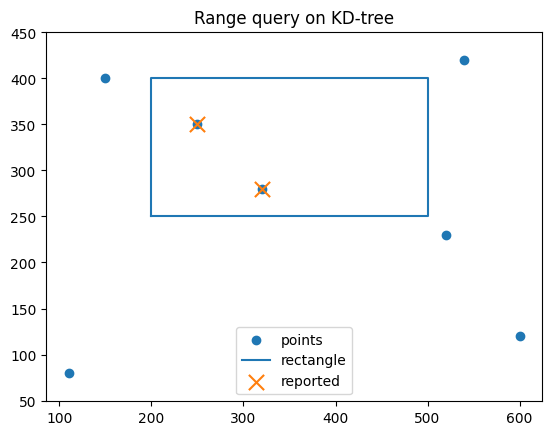

In [41]:
rect = Rect(200, 500, 250, 400)
ans = range_search(root, rect)

assert all(rect.contains(p) for p in ans)
print("All reported points are inside the rectangle")
print("Reported:", len(ans))
plot_range(small, rect, ans, title="Range query on KD-tree")

## Range Query — 200 Random Points

All reported points are inside the rectangle
Points: 200
Reported: 38


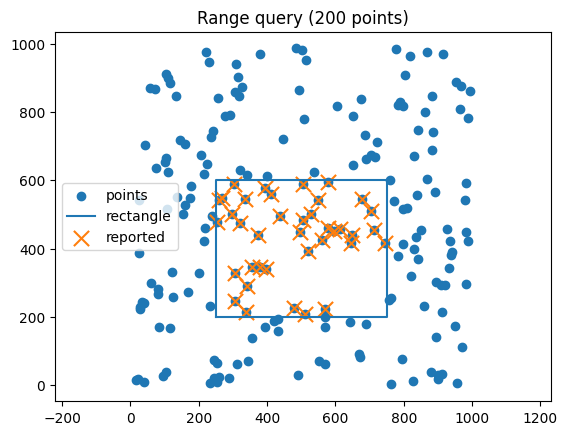

In [42]:
pts = random_points_2d(200, seed=1, lo=0, hi=1000)
root = build_kdtree(pts)

rect = Rect(250, 750, 200, 600)
ans = range_search(root, rect)

assert all(rect.contains(p) for p in ans)
print("All reported points are inside the rectangle")

print("Points:", len(pts))
print("Reported:", len(ans))
plot_range(pts, rect, ans, title="Range query (200 points)")